In [ ]:
# !pip install --upgrade diffusers

In [7]:
import os
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

In [20]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
# import PIL
from PIL import Image
from diffusers.utils import numpy_to_pil
from IPython import display
from diffusers import DDPMScheduler, DDPMPipeline

## diffusers

- pipeline： to generate samples（images）
    - `StableDiffusionPipeline`
        - 参数
            - `guidance_scale`, which determines how much the model will try to match the prompt.
    - `DDPMPipeline`
        - 构造函数接受两个输入：`(unet, scheduler)`
    - `pipe()`/`pipe.__call__()`: sampling/generating process
        - from a noise;
        - scheduler.
- Models
    - `UNet` => `transformers` (DiT, diffusion with transformers)
    - `from diffusers import UNet2DModel`
- Schedulers
    - DDPMScheduler (https://arxiv.org/abs/2006.11239)
        - 构造函数：
            - num_train_timesteps: int = 1000,
            - beta_start: float = 0.0001,
            - beta_end: float = 0.02,
            - beta_schedule: str = 'linear',
        - 核心函数
            - `scheduler.add_noise()`:  (x0s, epsilons, ts) => xts
                - input
                    - original_samples: torch.FloatTensor,
                    - noise: torch.FloatTensor,
                    - timesteps: torch.IntTensor,
                - output: noisy_images
            - scheduler.step()

In [21]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

    
def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### StableDiffusionPipeline

In [ ]:
from diffusers import StableDiffusionPipeline

# Check out https://huggingface.co/sd-dreambooth-library for loads of models from the community
model_id = "sd-dreambooth-library/mr-potato-head"

# Load the pipeline
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
    device
)

In [ ]:
pipe.components.keys()

In [ ]:
prompt = "an abstract oil painting of sks mr potato head by picasso"
images = pipe(prompt, num_inference_steps=50, guidance_scale=7.5, num_images_per_prompt=5).images

In [ ]:
images[2]

In [ ]:
make_grid(images)

### DDPMPipeline

In [ ]:
from diffusers import DDPMPipeline

# Load the butterfly pipeline
butterfly_pipeline = DDPMPipeline.from_pretrained(
    "johnowhitaker/ddpm-butterflies-32px"
).to(device)

# Create 8 images
images = butterfly_pipeline(batch_size=8).images

# View the result
make_grid(images)

In [ ]:
butterfly_pipeline.components.keys()

In [ ]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to("cuda")

In [ ]:
images = image_pipe().images

In [ ]:
images[0]

## images dataset

- demo images
    - https://ids.si.edu/ids/deliveryService?id=ark:/65665/m3b302800a43ef46b8a7a87a7b1eb06ab6

In [4]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# Or load images from a local folder
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 128
# You can lower your batch size if you're running out of GPU memory
batch_size = 32

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        # (0, 1) - 0.5 => [-0.5, 0.5]
        # [-0.5, 0.5] / 0.5 => [-1, 1]
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

/home/whaow/anaconda3/lib/python3.10/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [ ]:
next(iter(train_dataloader))['images'].shape

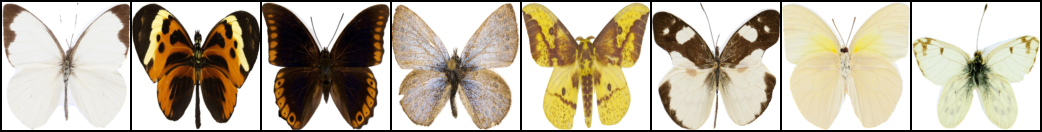

In [9]:
image_batch = next(iter(train_dataloader))['images'].to(device)[:8]
show_images(image_batch)

In [ ]:
len(train_dataloader)

In [ ]:
len(train_dataloader.dataset)

In [ ]:
1000/32

## Scheduler

- forward noising process (pixel space):

    $$
    \begin{split}
    &q(x_t|x_{t-1})\sim \mathcal N(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_t\mathbb I)\\
    &q(x_{1:T}|x_0)=\Pi_{t=1}^Tq(x_t|x_{t-1})\\
    &q(x_t|x_0)=\mathcal N(x_t;\sqrt{\bar \alpha_t}x_0,(1-\bar\alpha_t)I), \quad \alpha_i=1-\beta_i,\bar\alpha_t=\Pi_{i=1}^T\alpha_i
    \end{split}
    $$
    
    - **scale** $x_{t-1}$ by $\sqrt{1-\beta_t}$ and **add noise scaled by** $\beta_t$
    - 对比 VaE（为什么叫 diffusion 而不是一种 VAE, latent space）
        - Encoder：$q(z|x)$, $x_0\rightarrow z_T$
        - Decoder: $p(x|z)$, $z_T\rightarrow x_0$
    

In [5]:
from diffusers import DDPMScheduler

In [6]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [ ]:
noise_scheduler.config.beta_schedule, noise_scheduler.config.beta_start, noise_scheduler.config.beta_end

In [ ]:
torch.allclose(1- torch.linspace(0.0001, 0.02, 1000), noise_scheduler.alphas)

In [ ]:
torch.allclose(torch.cumprod(noise_scheduler.alphas, 0), noise_scheduler.alphas_cumprod)

In [ ]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

- $\bar\alpha_1, \bar\alpha_2, \bar\alpha_3, ..., \bar\alpha_t$：是逐渐变小的过程

In [ ]:
# One with too little noise added:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)
# The 'cosine' schedule, which may be better for small image sizes:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

In [7]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
timesteps.shape

torch.Size([8])

In [10]:
noise = torch.randn_like(image_batch)
noise.shape

torch.Size([8, 3, 128, 128])

In [ ]:
# noise_scheduler.add_noise??

In [11]:
noisy_image_batch = noise_scheduler.add_noise(image_batch, noise, timesteps)

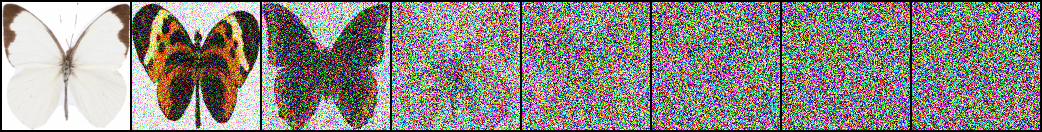

In [12]:
show_images(noisy_image_batch)

## UNet (denoising model)

In [13]:
from diffusers import UNet2DModel

- U-Net: Convolutional Networks for Biomedical Image Segmentation: https://arxiv.org/abs/1505.04597
- downsample: ResNet blocks
- #downsamples == #upsamples
    - down_block_types
    - up_block_types
- skip connection linking features of (downsample / upsample)
- output size == input size

In [ ]:
display.Image(url='https://i.imgur.com/S7KH5hZ.png', width=600)

$$
\epsilon_\theta(x_t, t)
$$

- unet denoising model
    - input: $(x_t, t)$
    - output 是添加在 $x_t$ 上的 noise；

In [ ]:
display.Image(url='https://camo.githubusercontent.com/2c676413dda1f487521dd5c1e5c4b35b8cfbf06d50880e15660ea44bd76eac6f/68747470733a2f2f68756767696e67666163652e636f2f64617461736574732f68756767696e67666163652f646f63756d656e746174696f6e2d696d616765732f7265736f6c76652f6d61696e2f756e65742d6d6f64656c2e706e67', 
              width=600)

In [14]:
repo_id = "google/ddpm-church-256"
unet = UNet2DModel.from_pretrained(repo_id)

In [ ]:
torch.manual_seed(0)

noisy_sample = torch.randn(
    1, unet.config.in_channels, unet.config.sample_size, unet.config.sample_size
)
noisy_sample.shape

In [ ]:
# unet.config

In [ ]:
# unet = UNet2DModel(sample_size=image_size, 
#                    in_channels=3, 
#                    out_channels=3, 
#                    layers_per_block=2, 
#                    block_out_channels=[64, 128, 128, 256], 
#                    down_block_types=['DownBlock2D', 
#                                      'DownBlock2D', # a regular ResNet downsampling block
#                                      'AttnDownBlock2D', # a ResNet downsampling block with spatial self-attention
#                                      'AttnDownBlock2D'], 
#                    up_block_types=['AttnUpBlock2D', 
#                                    'AttnUpBlock2D', # a ResNet upsampling block with spatial self-attention
#                                    'UpBlock2D', 
#                                    'UpBlock2D', # a regular ResNet upsampling block
#                                   ])
# unet = unet.to(device)
# # unet

In [17]:
unet = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D", 
        "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D"  
      ),
)
unet = unet.to(device)

In [ ]:
unet.forward??

In [18]:
# (image, t)
with torch.no_grad():
    model_pred = unet(noisy_image_batch, timesteps).sample
model_pred.shape

torch.Size([8, 3, 128, 128])

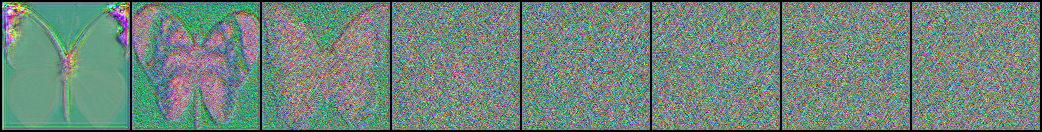

In [19]:
show_images(model_pred)

In [20]:
mean = model_pred.view(model_pred.size(0), -1).mean(dim=1)
var = model_pred.view(model_pred.size(0), -1).var(dim=1)
print(mean, var)

tensor([ 0.0202, -0.0213, -0.0003,  0.0028, -0.0013,  0.0075,  0.0124,  0.0131],
       device='cuda:0') tensor([0.0690, 0.0971, 0.0907, 0.0932, 0.0973, 0.0962, 0.0948, 0.0962],
       device='cuda:0')


## training

In [21]:
from tqdm.notebook import tqdm

In [35]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(unet.parameters(), lr=4e-4)

losses = []

for epoch in tqdm(range(80), 'epochs'):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave='False'):
        # x0
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = unet(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

epochs:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch:5, loss: 0.034594995609950274


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch:10, loss: 0.034592534706462175


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch:15, loss: 0.03625397372525185


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch:20, loss: 0.03347752909758128


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch:25, loss: 0.03837961482349783


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch:30, loss: 0.03068095343769528


| image size | batch size | dataset | epochs |  time  |
|:----------:|:----------:|---------|:------:|:------:|
| 32 * 32    | 64         | 1000    | 30     | 3mins  |
| 128 * 128  | 32         | 1000    | 30     | 9mins  |
| 256 * 256  | 16         | 1000    | 30     | 43mins |

In [30]:
losses[0], losses[-1]

(0.06618157774209976, 0.0203472338616848)

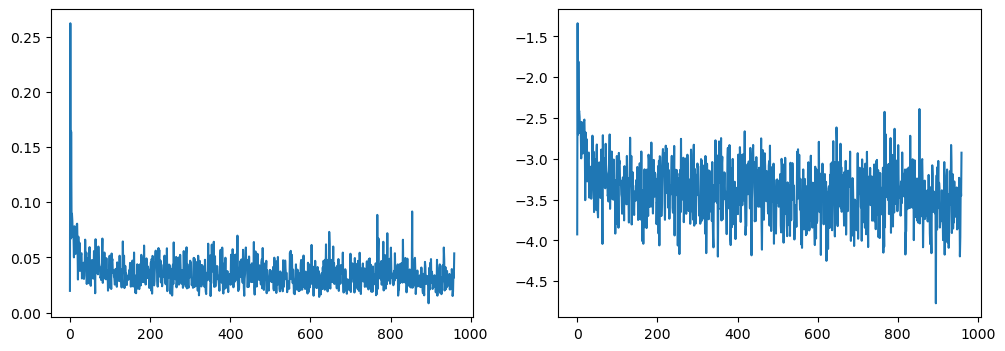

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(losses)
axes[1].plot(np.log(losses))

## generate images

In [32]:
image_pipe = DDPMPipeline(unet=unet, scheduler=noise_scheduler)

In [ ]:
image_pipe??

In [ ]:
noise_scheduler.step??

  0%|          | 0/1000 [00:00<?, ?it/s]

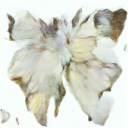

In [33]:
image_pipe().images[0]

In [ ]:
display.Image(url='https://i.imgur.com/S7KH5hZ.png', width=600)

In [ ]:
image_pipe.save_pretrained("my_pipeline")

  0%|          | 0/1000 [00:00<?, ?it/s]

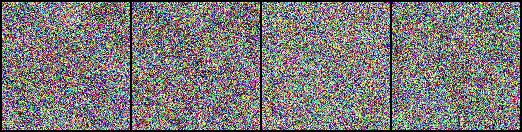

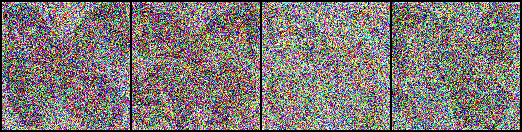

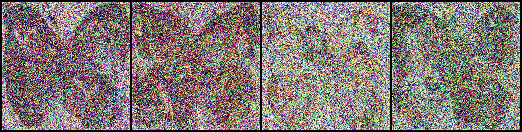

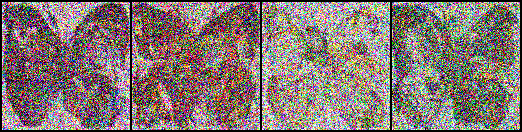

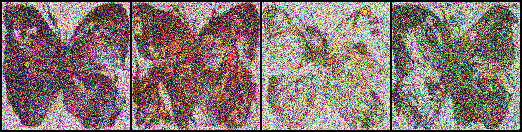

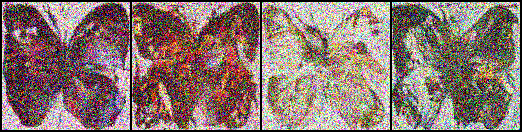

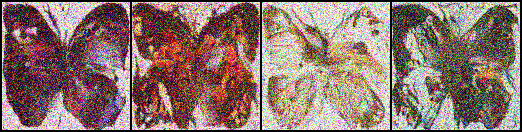

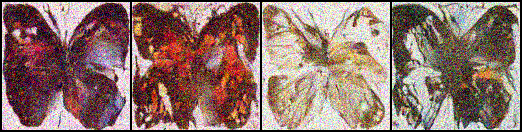

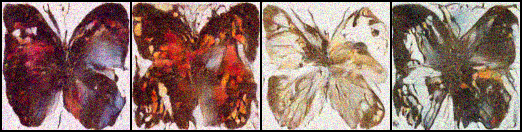

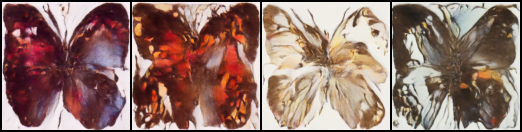

In [37]:
sample = torch.randn(4, unet.config.in_channels, unet.config.sample_size, unet.config.sample_size)
sample = sample.to(device)

for i, t in enumerate(tqdm(noise_scheduler.timesteps)):
  # 1. predict noise residual
    with torch.no_grad():
        residual = unet(sample, t).sample
    # 2. compute less noisy image and set x_t -> x_t-1
    sample = noise_scheduler.step(residual, t, sample).prev_sample

    # 3. optionally look at image
    if (i + 1) % 100 == 0:
        display.display(show_images(sample))

```
image = randn_tensor(image_shape, generator=generator, device=self.device)

# set step values
self.scheduler.set_timesteps(num_inference_steps)

for t in self.progress_bar(self.scheduler.timesteps):
    # 1. predict noise model_output
    model_output = self.unet(image, t).sample

    # 2. compute previous image: x_t -> x_t-1
    image = self.scheduler.step(model_output, t, image, generator=generator).prev_sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()
if output_type == "pil":
    image = self.numpy_to_pil(image)
```


```
t = timestep

prev_t = self.previous_timestep(t)

if model_output.shape[1] == sample.shape[1] * 2 and self.variance_type in ["learned", "learned_range"]:
    model_output, predicted_variance = torch.split(model_output, sample.shape[1], dim=1)
else:
    predicted_variance = None

# 1. compute alphas, betas
alpha_prod_t = self.alphas_cumprod[t]
alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
beta_prod_t = 1 - alpha_prod_t
beta_prod_t_prev = 1 - alpha_prod_t_prev
current_alpha_t = alpha_prod_t / alpha_prod_t_prev
current_beta_t = 1 - current_alpha_t

# 2. compute predicted original sample from predicted noise also called
# "predicted x_0" of formula (15) from https://arxiv.org/pdf/2006.11239.pdf
if self.config.prediction_type == "epsilon":
    pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)
elif self.config.prediction_type == "sample":
    pred_original_sample = model_output
elif self.config.prediction_type == "v_prediction":
    pred_original_sample = (alpha_prod_t**0.5) * sample - (beta_prod_t**0.5) * model_output
else:
    raise ValueError(
        f"prediction_type given as {self.config.prediction_type} must be one of `epsilon`, `sample` or"
        " `v_prediction`  for the DDPMScheduler."
    )

# 3. Clip or threshold "predicted x_0"
if self.config.thresholding:
    pred_original_sample = self._threshold_sample(pred_original_sample)
elif self.config.clip_sample:
    pred_original_sample = pred_original_sample.clamp(
        -self.config.clip_sample_range, self.config.clip_sample_range
    )

# 4. Compute coefficients for pred_original_sample x_0 and current sample x_t
# See formula (7) from https://arxiv.org/pdf/2006.11239.pdf
pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * current_beta_t) / beta_prod_t
current_sample_coeff = current_alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t

# 5. Compute predicted previous sample µ_t
# See formula (7) from https://arxiv.org/pdf/2006.11239.pdf
pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * sample

# 6. Add noise
variance = 0
if t > 0:
    device = model_output.device
    variance_noise = randn_tensor(
        model_output.shape, generator=generator, device=device, dtype=model_output.dtype
    )
    if self.variance_type == "fixed_small_log":
        variance = self._get_variance(t, predicted_variance=predicted_variance) * variance_noise
    elif self.variance_type == "learned_range":
        variance = self._get_variance(t, predicted_variance=predicted_variance)
        variance = torch.exp(0.5 * variance) * variance_noise
    else:
        variance = (self._get_variance(t, predicted_variance=predicted_variance) ** 0.5) * variance_noise

pred_prev_sample = pred_prev_sample + variance
```

$$
\begin{split}
&x_0\approx \hat x_0 = (x_t-\sqrt{1-\bar\alpha_t}\epsilon_\theta(x_t))\sqrt{\bar\alpha_t},\quad (15)\\
&q(x_{t-1}|x_t,x_0)=\mathcal N(x_{t-1};\tilde\mu_t(x_t,x_0),\tilde\beta_tI),\quad (6)\\
&\tilde\mu_t(x_t,x_0):=\frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1-\bar\alpha_t}x_0+\frac{\sqrt{\alpha_t}{(1-\bar\alpha_{t-1})}}{1-\bar\alpha_t}x_t\\
&\tilde\beta_t:=\frac{1-\bar\alpha_{t-1}}{1-\bar\alpha_t}\beta_t,\quad (7)
\end{split}
$$

## accelerate

In [1]:
from huggingface_hub import get_full_repo_name

In [5]:
# !wget https://github.com/huggingface/diffusers/raw/main/examples/unconditional_image_generation/train_unconditional.py

In [9]:
get_full_repo_name??

In [8]:
model_name = "sd-class-butterflies-64"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'lanchunhui/sd-class-butterflies-64'

In [11]:
# !accelerate launch train_unconditional.py \
#   --dataset_name="huggan/smithsonian_butterflies_subset" \
#   --resolution=64 \
#   --output_dir={model_name} \
#   --train_batch_size=128 \
#   --num_epochs=50 \
#   --gradient_accumulation_steps=1 \
#   --learning_rate=1e-4 \
#   --lr_warmup_steps=500 \
#   --mixed_precision="no"

In [12]:
from diffusers import DDPMPipeline

[2024-03-11 22:55:24,807] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [16]:
image_pipe = DDPMPipeline.from_pretrained('./sd-class-butterflies-64/').to(device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

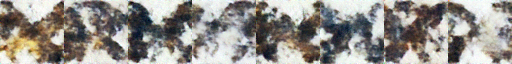

In [23]:
make_grid(image_pipe(batch_size=8)['images'])